### This model is a combination of the camera_CNN_Multiclass and instagram_CNN_Multiclass

The first iteration was the camera_CNN_Multiclass, and the issue with that was that the dataset was not large enough(only 4000). The instagram_CNN_Multiclass handled that error with the Fair Face dataset, but it was unable to detect camera filters like sepia, black and white, etc. So this model combines both of them. Also, the camera_CNN_Multiclass did not apply varying levels of contrast and brightness to the training images, that will be done here. 

It's important to note that when training, the training set was limited to around 260k images. By increasing the folder cap from 20k to 84k (maximum, but might want to maintain an equal balance for the different filter datasets), we can increase the training sample to around 650k. This would probably improve the model, but you would need a good gpu. The one used here is the g5 2x from aws ec2.

# Imports

In [47]:
import torch
import torchvision
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

import os
import random
from PIL import Image, ImageEnhance, ImageFilter

from IPython.display import Image as ImagePy
from IPython.core.display import HTML 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset Preparation

Like the instagram_CNN_Multiclass, we uploaded the Fair Face dataset and Fair Beauty dataset as unfiltered and filtered images under our folder called dataset. But now we also want to apply the camera filters to our Fair Face unfiltered dataset. Our structure currently looks like this:

and we will add our camera filters folder so that it is now:

# Apply Camera Filters

For every filter, we must account for variation. The varying values can be seen under each apply_filter function. Instead of increasing the min and max range equally, only the max range is increased to the extreme. Ultimately, we just want to highlight the images that we can't work with, so the filters with low values won't really matter.


(Model 2 v2 update) We will also do this now for our added filter, cool, and for sepia, black and white, and blur.


(Model 4 update) We will also add warmth.

In [ ]:
import os
import random
from PIL import Image, ImageEnhance, ImageFilter


base_dir = 'dataset'

camera_filters = ["brightness", "contrast", "sepia", "black_and_white", "blur", "cool", "warmth"]

camera_filtered_dir = os.path.join(base_dir, 'camera_filtered')
os.makedirs(camera_filtered_dir, exist_ok=True)

def apply_varied_sepia_filter(img):
    sepia_img = img.convert("L").convert("RGB")
    pixels = sepia_img.load()
    for y in range(sepia_img.size[1]):
        for x in range(sepia_img.size[0]):
            r, g, b = pixels[x, y]
            red = int(r * random.uniform(0.385, 0.6) + g * random.uniform(0.76, 1.0) + b * random.uniform(0.18, 0.4))
            green = int(r * random.uniform(0.34, 0.6) + g * random.uniform(0.676, 1.0) + b * random.uniform(0.16, 0.4))
            blue = int(r * random.uniform(0.265, 0.6) + g * random.uniform(0.524, 1.0) + b * random.uniform(0.12, 0.4))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return sepia_img

def apply_varied_cool_filter(img):
    cool_img = img.convert("RGB")
    pixels = cool_img.load()
    for y in range(cool_img.size[1]):
        for x in range(cool_img.size[0]):
            r, g, b = pixels[x, y]
            blue = int(b * random.uniform(1.1, 2.0))
            red = int(r * random.uniform(0.8, 0.95))
            green = int(g * random.uniform(0.8, 0.95))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return cool_img

def apply_varied_blur_filter(img):
    radius = random.uniform(2, 6)
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def apply_varied_black_and_white_filter(img):
    bw_img = img.convert("L")
    pixels = bw_img.load()
    for y in range(bw_img.size[1]):
        for x in range(bw_img.size[0]):
            if random.random() < 0.05:
                pixels[x, y] = pixels[x, y] + random.randint(-30, 30)
    return bw_img

def apply_varied_warmth_filter(img):
    warmth_img = img.convert("RGB")
    pixels = warmth_img.load()
    for y in range(warmth_img.size[1]):
        for x in range(warmth_img.size[0]):
            r, g, b = pixels[x, y]
            red = int(r * random.uniform(1.05, 1.4))
            green = int(g * random.uniform(0.85, 1.1))
            pixels[x, y] = (min(red, 255), min(green, 255), b)
    return warmth_img

def apply_camera_filter(img, filter_name):
    if filter_name == "brightness":
        enhancer = ImageEnhance.Brightness(img)
        factor = random.uniform(1.0, 3.0)
        return enhancer.enhance(factor)
    elif filter_name == "contrast":
        enhancer = ImageEnhance.Contrast(img)
        factor = random.uniform(1.0, 5.0)
        return enhancer.enhance(factor)
    elif filter_name == "sepia":
        return apply_varied_sepia_filter(img)
    elif filter_name == "black_and_white":
        return apply_varied_black_and_white_filter(img)
    elif filter_name == "blur":
        return apply_varied_blur_filter(img)
    elif filter_name == "cool":
        return apply_varied_cool_filter(img)
    elif filter_name == "warmth":
        return apply_varied_warmth_filter(img)
    else:
        return img

def process_and_save_images(source_dir, target_dir, filter_name, cap):

    all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    selected_files = random.sample(all_files, min(cap, len(all_files)))
    
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        with Image.open(source_path) as img:
            filtered_img = apply_camera_filter(img, filter_name)
            target_file_dir = os.path.join(target_dir, filter_name)
            os.makedirs(target_file_dir, exist_ok=True)
            filtered_img.save(os.path.join(target_file_dir, file))


for subdir, cap in [('train', 40000), ('val', 3000)]:
    source_subdir = os.path.join(base_dir, 'unfiltered', subdir)
    target_subdir = os.path.join(camera_filtered_dir, subdir)
    for filter_name in camera_filters:
        process_and_save_images(source_subdir, target_subdir, filter_name, cap)


# Count the images in each dataset

In [48]:
def count_images(folder):
    files = os.listdir(folder)
    images = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    return len(images)

#### For our unfiltered dataset:

In [49]:
unfiltered_folder = "dataset/unfiltered"

for filter_name in os.listdir(unfiltered_folder):
    filter_folder = os.path.join(unfiltered_folder, filter_name)
    if os.path.isdir(filter_folder):
        num_filtered_images = count_images(filter_folder)
        print(f'Number of {filter_name} unfiltered images: {num_filtered_images}')

Number of train unfiltered images: 86744
Number of val unfiltered images: 10954


#### For our camera_filtered dataset:

In [50]:
camera_filtered = 'dataset/camera_filtered'

for subdir in ['train', 'val']:
    subdir_path = os.path.join(camera_filtered, subdir)
    for filter_name in ["brightness", "contrast", "sepia", "black_and_white", "blur", "cool", "warmth"]:
        filter_dir = os.path.join(subdir_path, filter_name)
        num_images = count_images(filter_dir)
        print(f"Number of {filter_name} images in {subdir}: {num_images}")

Number of brightness images in train: 40389
Number of contrast images in train: 40000
Number of sepia images in train: 40000
Number of black_and_white images in train: 40000
Number of blur images in train: 40000
Number of cool images in train: 40000
Number of warmth images in train: 40000
Number of brightness images in val: 3000
Number of contrast images in val: 3000
Number of sepia images in val: 3000
Number of black_and_white images in val: 3000
Number of blur images in val: 3000
Number of cool images in val: 3000
Number of warmth images in val: 3000


#### For our (instagram) filtered dataset:

This folder is organized differently since it has a bunch of sub folders in batches. We will address this issue when we build our Dataset Class.

We did this in our instagram_CNN_multiclass.

# Define Dataset Class

As can be seen, the Fair Face Dataset came with a train folder and a val folder that both contained images of unfiltered images, so labeling those were very simple.


For the Fair Beauty Dataset, each train and val folder came with separate batches of around 900 images. These batch folders had their own filters that were applied to the images, and these were out of the 8 instagram filters. So using the filter index file, I labeled each of the images using with this legend:

- None: 0
- Pretty: 1
- hary beauty: 2
- Shiny foxy: 3
- Caramel Macchiato: 4
- Cute baby face: 5
- Baby_cute_face: 6
- big city life: 7
- Just Baby: 8
- brightness: 9
- contrast: 10
- sepia: 11
- black_and_white: 12
- blur: 13
- cool: 14

In [89]:
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader

class MultiClassDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.base_dir = base_dir
        self.split = split
        self.transform = transform
        self.labels = {
            "None": 0, "Pretty": 1, "hary beauty": 2, "Shiny foxy": 3,
            "Caramel Macchiato": 4, "Cute baby face": 5, "Baby_cute_face": 6,
            "big city life": 7, "Just Baby": 8, "brightness": 9, "contrast": 10,
            "sepia": 11, "black_and_white": 12, "blur": 13, "cool": 14, "warmth": 15
        }
        self.image_paths = []
        self.image_labels = []
        
        unfiltered_dir = os.path.join(base_dir, 'unfiltered', split)
        for img_name in os.listdir(unfiltered_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                self.image_paths.append(os.path.join(unfiltered_dir, img_name))
                self.image_labels.append(0)
                
        self.process_directory('filtered', None)
        self.process_directory('camera_filtered', None)

        self.reduce_images_for_camera_filters()

    
    def process_directory(self, dir_name, default_label):
        dir_path = os.path.join(self.base_dir, dir_name, self.split)
        for label_dir in os.listdir(dir_path):
            label_name = self.get_label_name(label_dir, self.split) if default_label is None else default_label
            if label_name in self.labels:
                full_dir = os.path.join(dir_path, label_dir)
                for img_name in os.listdir(full_dir):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        self.image_paths.append(os.path.join(full_dir, img_name))
                        self.image_labels.append(self.labels[label_name])

    def reduce_images_for_camera_filters(self):
        target_count = 40000 if self.split == 'train' else 2000
        for filter_label in range(1, 16):
            self.reduce_images_for_label(filter_label, target_count)

    def reduce_images_for_label(self, label, target_count):
        indices = [i for i, l in enumerate(self.image_labels) if l == label]
        if len(indices) > target_count:
            indices_to_remove = random.sample(indices, len(indices) - target_count)
            indices_to_remove.sort(reverse=True)
            for idx in indices_to_remove:
                del self.image_paths[idx]
                del self.image_labels[idx]
                
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

    def get_label_name(self, folder_name, split):

        # I used chat gpt and gave it the filter index file and then all the file names,
        # and it did its work to produce this map
        
        if split == 'train':
            mapping = {
"000000": "Caramel Macchiato", "001000": "Caramel Macchiato",
                "002000": "Cute baby face", "003000": "Caramel Macchiato",
                "004000": "Cute baby face", "005000": "Baby_cute_face",
                "006000": "Caramel Macchiato", "007000": "Cute baby face",
                "008000": "Baby_cute_face", "009000": "big city life",
                "010000": "Caramel Macchiato", "011000": "Cute baby face",
                "012000": "Baby_cute_face", "013000": "big city life",
                "014000": "Caramel Macchiato", "015000": "Cute baby face",
                "016000": "Baby_cute_face", "017000": "big city life",
                "018000": "Caramel Macchiato", "019000": "Cute baby face",
                "020000": "Baby_cute_face", "021000": "big city life",
                "022000": "hary beauty", "023000": "Pretty",
                "024000": "Shiny foxy", "025000": "Just Baby",
                "026000": "hary beauty", "027000": "Pretty",
                "028000": "Shiny foxy", "029000": "Just Baby",
                "030000": "hary beauty", "031000": "Pretty",
                "032000": "Shiny foxy", "033000": "Just Baby",
                "034000": "hary beauty", "035000": "Pretty",
                "036000": "Shiny foxy", "037000": "Just Baby",
                "038000": "hary beauty", "039000": "Pretty",
                "040000": "Shiny foxy", "041000": "Just Baby",
                "042000": "hary beauty", "043000": "Pretty",
                "044000": "Shiny foxy", "045000": "Just Baby",
                "046000": "hary beauty", "047000": "Pretty",
                "048000": "Shiny foxy", "049000": "Just Baby",
                "050000": "hary beauty", "051000": "Pretty",
                "052000": "Shiny foxy", "053000": "Just Baby",
                "054000": "hary beauty", "055000": "Pretty",
                "056000": "Shiny foxy", "057000": "Just Baby",
                "058000": "hary beauty", "059000": "Pretty",
                "060000": "Shiny foxy", "061000": "Just Baby",
                "062000": "hary beauty", "063000": "Pretty",
                "064000": "Shiny foxy", "065000": "Just Baby",
                "066000": "big city life", "067000": "Baby_cute_face",
                "068000": "Cute baby face", "069000": "Caramel Macchiato",
                "070000": "big city life", "071000": "Baby_cute_face",
                "072000": "Cute baby face", "073000": "Caramel Macchiato",
                "074000": "big city life", "075000": "Baby_cute_face",
                "076000": "Cute baby face", "077000": "Caramel Macchiato",
                "078000": "big city life", "079000": "Baby_cute_face",
                "080000": "Cute baby face", "081000": "Caramel Macchiato",
                "082000": "big city life", "083000": "Baby_cute_face",
                "084000": "Cute baby face", "085000": "big city life",
                "086000": "Caramel Macchiato", "brightness": "brightness", 
                "contrast": "contrast", "sepia": "sepia", 
                "black_and_white": "black_and_white", "blur": "blur",
                "cool": "cool", "warmth": "warmth"
            }

                    
        # Same for the val dataset in the filtered folder, since the
        # index mappings were different
        
        elif split == 'val':
            mapping = {
                "000000": "Pretty", "001000": "hary beauty",
                "002000": "Shiny foxy", "003000": "Caramel Macchiato",
                "004000": "Cute baby face", "005000": "Baby_cute_face",
                "006000": "big city life", "007000": "Just Baby",
                "008000": "Pretty", "009000": "hary beauty",
                "010000": "Shiny foxy", "brightness": "brightness", 
                "contrast": "contrast", "sepia": "sepia", 
                "black_and_white": "black_and_white", "blur": "blur",
                "cool": "cool", "warmth": "warmth"
            }
        return mapping.get(folder_name, None)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

batch_size = 32

train_dataset = MultiClassDataset(base_dir='dataset', split='train', transform=transform)
val_dataset = MultiClassDataset(base_dir='dataset', split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

#### Side note:

When we created the images for the camera_filtered, we used every unfiltered image in unfiltered_train and unfiltered_val. This means each filter folder is around 80k for the training set and 10k for the val set. So in our dataset class we prevent imbalance by keeping a cap of around 20k for training and 1200 for val for the camera_filtered folders, which is the same as the instagram filters we used. These are the 'reduce' functions.

Another reason why each of the sets are capped at 20k per folder is the specs of the graphics driver. With a better gpu, can use more data and thus will most likely have a better model.

# Count images per label

In [90]:
from collections import Counter

label_counts = Counter(train_dataset.image_labels)

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Label 0: 86744 images
Label 7: 8999 images
Label 5: 9901 images
Label 2: 9983 images
Label 8: 9809 images
Label 1: 9882 images
Label 6: 8979 images
Label 4: 10511 images
Label 3: 9910 images
Label 13: 40000 images
Label 10: 40000 images
Label 12: 40000 images
Label 9: 40000 images
Label 14: 40000 images
Label 15: 40000 images
Label 11: 40000 images


In [91]:
from collections import Counter

label_counts = Counter(val_dataset.image_labels)

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Label 0: 10954 images
Label 6: 915 images
Label 7: 906 images
Label 1: 1745 images
Label 8: 904 images
Label 2: 1774 images
Label 3: 1752 images
Label 4: 903 images
Label 5: 907 images
Label 13: 2000 images
Label 10: 2000 images
Label 12: 2000 images
Label 9: 2000 images
Label 14: 2000 images
Label 15: 2000 images
Label 11: 2000 images


In [92]:
print("Length of Train Dataset:", len(train_dataset))
print("Length of Validation Dataset:", len(val_dataset))

Length of Train Dataset: 444718
Length of Validation Dataset: 34760


# Define Model

(Using Model 2 from Past Models)

In [79]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='valid', bias=False)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.dropout3(self.act3(self.conv3(x))))
        x = self.bn4(self.dropout4(self.act4(self.conv4(x))))
        
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


model = CNNModel(num_classes=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Evaluate the model without training

Since we have 16 classes, this should be about 1/16 = 6.25%

In [ ]:
import torch

def evaluate_model_per_class(model, data_loader, class_names):
    model.eval()
    class_correct = list(0. for i in range(len(class_names)))
    class_total = list(0. for i in range(len(class_names)))
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(len(class_names)):
        print(f'Accuracy of {class_names[i]} : {(100 * class_correct[i] / class_total[i]):.2f}%')

    total_correct = sum(class_correct)
    total = sum(class_total)
    total_accuracy = 100 * total_correct / total
    print(f'\nTotal Accuracy: {total_accuracy:.2f}%')

class_names = ["None", "brightness", "contrast", "sepia", "black_and_white", "cool", "warmth"]
evaluate_model_per_class(model, val_loader, class_names)

# Training

Save checkpoint every epoch.

Average time per epoch is 10 minutes

In [ ]:
checkpoint_dir = 'checkpoints_camera_instagram'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_accuracy = correct_preds / total_preds
    train_loss = running_loss / len(train_loader)

    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)
            val_running_loss += loss.item()

    val_accuracy = val_correct_preds / val_total_preds
    val_loss = val_running_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


    print("Saving Epoch: " + str(epoch+1))
    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f'model_{epoch+1}.pth'))
    print(f'Checkpoint saved at epoch {epoch+1}')


# Evaluate Per Class

In [ ]:
import torch

model.eval()

def evaluate_model_per_class(model, data_loader, num_classes):
    model.eval()
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for label, prediction in zip(labels, predicted):
                if label == prediction:
                    correct_per_class[label] += 1
                total_per_class[label] += 1

    for i in range(num_classes):
        accuracy = 100 * correct_per_class[i] / total_per_class[i] if total_per_class[i] != 0 else 0
        print(f'Accuracy of class {i}: {accuracy:.2f}%')

evaluate_model_per_class(model, val_loader, 16)

# Graphing Loss and Accuracy

In [ ]:

data = [
]

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


for item in data:
    train_losses.append(item["Train Loss"])
    val_losses.append(item["Val Loss"])
    train_accuracies.append(item["Train Accuracy"])
    val_accuracies.append(item["Val Accuracy"])

epochs = list(range(1, 27))

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.1)
plt.show()



plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)
plt.show()


# Displaying incorrect ouptuts

To get a qualitative understanding of what the model gets wrong, we will evaluate it on a small subset of our valdiation set and display the incorrect outputs.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os


checkpoint_path = os.path.join('checkpoints_camera_instagram', 'model1.pth')
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
subset_size = int(len(val_loader.dataset) * 0.1)
incorrect_images = []
incorrect_labels = []
predicted_labels = []
total_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)

        total_loss += loss.item() * images.size(0)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        wrong_indices = (predicted != labels)
        if wrong_indices.any():
            incorrect_images.extend(images[wrong_indices].cpu().numpy())
            incorrect_labels.extend(labels[wrong_indices].cpu().numpy())
            predicted_labels.extend(predicted[wrong_indices].cpu().numpy())

        if len(incorrect_images) >= subset_size:
            break

accuracy = (total_correct / total_samples) * 100
average_loss = total_loss / total_samples
print(f'Validation Accuracy: {accuracy:.2f}%')
print(f'Validation Loss: {average_loss:.4f}')
num_to_show = min(len(incorrect_images), 10)


num_rows = 1
num_cols = num_to_show
fig, axes = plt.subplots(num_rows, num_cols, figsize=(2*num_cols, 2*num_rows))
if num_to_show == 1:
    axes = [axes]
for i, ax in enumerate(axes):
    img = np.transpose(incorrect_images[i], (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.set_title(f'Pred: {predicted_labels[i]}, True: {incorrect_labels[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Past Trials

# Model 1 (Instagram_CNN_Multiclass best model)

Key Details about this model were that the testing filtered image folder cap was at 6000, and that it had a decreasing kernel size. So it started with many filters and gradually reduced it over 3 convolutional layers.

In [61]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=14):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.act3(self.conv3(x)))
        
        # Global max pooling
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes=14).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

- Epoch [1/30], Train Loss: 1.0985, Train Accuracy: 0.6622, Val Loss: 0.7466, Val Accuracy: 0.7599
- Epoch [2/30], Train Loss: 0.6171, Train Accuracy: 0.7820, Val Loss: 0.6200, Val Accuracy: 0.7927
- Epoch [3/30], Train Loss: 0.5139, Train Accuracy: 0.8185, Val Loss: 0.4604, Val Accuracy: 0.8460
- Epoch [4/30], Train Loss: 0.4571, Train Accuracy: 0.8378, Val Loss: 0.4400, Val Accuracy: 0.8509
- Epoch [5/30], Train Loss: 0.4224, Train Accuracy: 0.8500, Val Loss: 0.4305, Val Accuracy: 0.8477
- Epoch [6/30], Train Loss: 0.3971, Train Accuracy: 0.8588, Val Loss: 0.3713, Val Accuracy: 0.8678
- Epoch [7/30], Train Loss: 0.3768, Train Accuracy: 0.8661, Val Loss: 0.3656, Val Accuracy: 0.8707
- Epoch [8/30], Train Loss: 0.3602, Train Accuracy: 0.8715, Val Loss: 0.3155, Val Accuracy: 0.8923
- Epoch [9/30], Train Loss: 0.3444, Train Accuracy: 0.8771, Val Loss: 0.2961, Val Accuracy: 0.8959
- Epoch [10/30], Train Loss: 0.3349, Train Accuracy: 0.8808, Val Loss: 0.2938, Val Accuracy: 0.8916
- Epoch [11/30], Train Loss: 0.3217, Train Accuracy: 0.8847, Val Loss: 0.3186, Val Accuracy: 0.8861
- Epoch [12/30], Train Loss: 0.3102, Train Accuracy: 0.8884, Val Loss: 0.3461, Val Accuracy: 0.8783
- Epoch [13/30], Train Loss: 0.2982, Train Accuracy: 0.8929, Val Loss: 0.2609, Val Accuracy: 0.9093
- Epoch [14/30], Train Loss: 0.2927, Train Accuracy: 0.8952, Val Loss: 0.2675, Val Accuracy: 0.9042
- Epoch [15/30], Train Loss: 0.2817, Train Accuracy: 0.8993, Val Loss: 0.2688, Val Accuracy: 0.9035
- Epoch [16/30], Train Loss: 0.2738, Train Accuracy: 0.9022, Val Loss: 0.2584, Val Accuracy: 0.9099
- Epoch [17/30], Train Loss: 0.2682, Train Accuracy: 0.9047, Val Loss: 0.2554, Val Accuracy: 0.9078

- Accuracy of class 0: 95.78%
- Accuracy of class 1: 67.68%
- Accuracy of class 2: 98.53%
- Accuracy of class 3: 93.05%
- Accuracy of class 4: 73.75%
- Accuracy of class 5: 85.78%
- Accuracy of class 6: 67.21%
- Accuracy of class 7: 99.56%
- Accuracy of class 8: 87.28%
- Accuracy of class 9: 53.58%
- Accuracy of class 10: 96.74%
- Accuracy of class 11: 99.47%
- Accuracy of class 12: 98.74%
- Accuracy of class 13: 99.89%

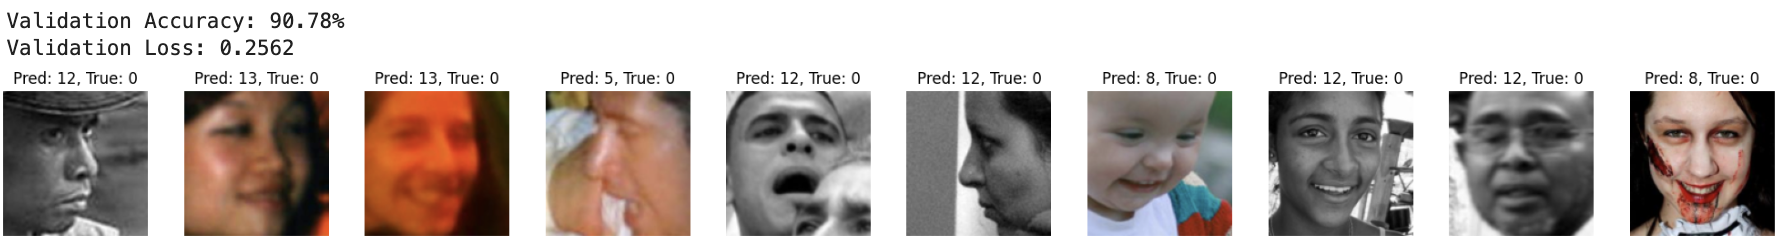

In [35]:
ImagePy(filename = "notebook_images/model1_outputs.png", width=2000, height=1000)

These were the incorrect outputs. These are just bad samples, for example many of the black and white photos are actually in black and white but came from the unfiltered dataset.

While this model does well on paper, it doesn't do well when tested on manually procured data by me. Especially the sepia filter. This is probably becasue when applying the filter to the images, it applies the same transformation without any variation.

# Model 2

This model uses 4 convolutional layers and caps the filtered data folders at 20000, and also increases kernel size, starting at 32. Since its a deeper model (with 1 more conv layer), dropout and batch normalization are added to 3rd and 4th conv layer to prevent overfitting.

The sepia folder is now altered, as we add variation in applying the filter.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=14):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='valid', bias=False)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.dropout3(self.act3(self.conv3(x))))
        x = self.bn4(self.dropout4(self.act4(self.conv4(x))))
        
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


model = CNNModel(num_classes=14).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

- Epoch [1/30], Train Loss: 0.8737, Train Accuracy: 0.7108, Val Loss: 0.6851, Val Accuracy: 0.7860
- Epoch [2/30], Train Loss: 0.5022, Train Accuracy: 0.8271, Val Loss: 0.5969, Val Accuracy: 0.7786
- Epoch [3/30], Train Loss: 0.4061, Train Accuracy: 0.8600, Val Loss: 0.4460, Val Accuracy: 0.8448

Performed significantly better on my manually procured dataset. Still was not able to capture the extreme images of sepia and a bluish image filter. The ones it got wrong were mainly images with light filters but could pass as normal images.

# Model 2 V2

To make our training set even more variational, varying sepia filters, blue filters, black and white filters, and now a new filter called "cool" will be added to the dataset of camera_filtered. Will now test using a folder cap of 20k for training and 1.5k for validation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding='valid', bias=False)
        self.act4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.dropout3(self.act3(self.conv3(x))))
        x = self.bn4(self.dropout4(self.act4(self.conv4(x))))
        
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


model = CNNModel(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Model 1, 2 V1 Camera Filter Apply

In [ ]:
base_dir = 'dataset'


camera_filters = ["brightness", "contrast", "sepia", "black_and_white", "blur"]


camera_filtered_dir = os.path.join(base_dir, 'camera_filtered')
os.makedirs(camera_filtered_dir, exist_ok=True)


def apply_camera_filter(img, filter_name):
    if filter_name == "brightness":
        enhancer = ImageEnhance.Brightness(img)
        factor = random.uniform(1.6, 2.0)
        return enhancer.enhance(factor)
    elif filter_name == "contrast":
        enhancer = ImageEnhance.Contrast(img)
        factor = random.uniform(2, 5)
        return enhancer.enhance(factor)
    elif filter_name == "sepia":
        sepia_img = img.convert("L").convert("RGB")
        pixels = sepia_img.load()
        for y in range(sepia_img.size[1]):
            for x in range(sepia_img.size[0]):
                r, g, b = pixels[x, y]
                red = int(r * 0.393 + g * 0.769 + b * 0.189)
                green = int(r * 0.349 + g * 0.686 + b * 0.168)
                blue = int(r * 0.272 + g * 0.534 + b * 0.131)
                pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
        return sepia_img
    elif filter_name == "black_and_white":
        return img.convert("L")
    elif filter_name == "blur":
        return img.filter(ImageFilter.GaussianBlur(radius=5))
    return img


def process_and_save_images(source_dir, target_dir, filter_name):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                source_path = os.path.join(root, file)
                with Image.open(source_path) as img:
                    filtered_img = apply_camera_filter(img, filter_name)
                    target_file_dir = os.path.join(target_dir, filter_name)
                    os.makedirs(target_file_dir, exist_ok=True)
                    filtered_img.save(os.path.join(target_file_dir, file))


for subdir in ['train', 'val']:
    for filter_name in camera_filters:
        source_dir = os.path.join(base_dir, f'unfiltered/{subdir}')
        target_dir = os.path.join(camera_filtered_dir, subdir)
        process_and_save_images(source_dir, target_dir, filter_name)


# Model 2 V2 Camera Filter Apply

In [ ]:
base_dir = 'dataset'
camera_filters = ["brightness", "contrast", "sepia", "black_and_white", "blur", "cool"]
camera_filtered_dir = os.path.join(base_dir, 'camera_filtered')
os.makedirs(camera_filtered_dir, exist_ok=True)

def apply_varied_sepia_filter(img):
    sepia_img = img.convert("L").convert("RGB")
    pixels = sepia_img.load()
    for y in range(sepia_img.size[1]):
        for x in range(sepia_img.size[0]):
            r, g, b = pixels[x, y]
            red = int(r * random.uniform(0.385, 0.6) + g * random.uniform(0.76, 1.0) + b * random.uniform(0.18, 0.4))
            green = int(r * random.uniform(0.34, 0.6) + g * random.uniform(0.676, 1.0) + b * random.uniform(0.16, 0.4))
            blue = int(r * random.uniform(0.265, 0.6) + g * random.uniform(0.524, 1.0) + b * random.uniform(0.12, 0.4))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return sepia_img

def apply_varied_cool_filter(img):
    cool_img = img.convert("RGB")
    pixels = cool_img.load()
    for y in range(cool_img.size[1]):
        for x in range(cool_img.size[0]):
            r, g, b = pixels[x, y]
            blue = int(b * random.uniform(1.1, 2.0))
            red = int(r * random.uniform(0.8, 0.95))
            green = int(g * random.uniform(0.8, 0.95))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return cool_img


def apply_varied_blur_filter(img):
    radius = random.uniform(2, 6)
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def apply_varied_black_and_white_filter(img):
    bw_img = img.convert("L")
    pixels = bw_img.load()
    for y in range(bw_img.size[1]):
        for x in range(bw_img.size[0]):
            if random.random() < 0.05:
                pixels[x, y] = pixels[x, y] + random.randint(-30, 30)
    return bw_img

def apply_camera_filter(img, filter_name):
    if filter_name == "brightness":
        enhancer = ImageEnhance.Brightness(img)
        factor = random.uniform(1.6, 2.0)
        return enhancer.enhance(factor)
    elif filter_name == "contrast":
        enhancer = ImageEnhance.Contrast(img)
        factor = random.uniform(2, 5)
        return enhancer.enhance(factor)
    elif filter_name == "sepia":
        return apply_varied_sepia_filter(img)
    elif filter_name == "black_and_white":
        return apply_varied_black_and_white_filter(img)
    elif filter_name == "blur":
        return apply_varied_blur_filter(img)
    elif filter_name == "cool":
        return apply_varied_cool_filter(img)
    return img


sepia_counter = 0

def process_and_save_images(source_dir, target_dir, filter_name):
    global sepia_counter
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if filter_name == "sepia" and sepia_counter >= 26000:
                return
            
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                source_path = os.path.join(root, file)
                with Image.open(source_path) as img:
                    filtered_img = apply_camera_filter(img, filter_name)
                    target_file_dir = os.path.join(target_dir, filter_name)
                    os.makedirs(target_file_dir, exist_ok=True)
                    filtered_img.save(os.path.join(target_file_dir, file))
                    
                    if filter_name == "sepia":
                        sepia_counter += 1

for subdir in ['train', 'val']:
    for filter_name in camera_filters:
        source_dir = os.path.join(base_dir, f'unfiltered/{subdir}')
        target_dir = os.path.join(camera_filtered_dir, subdir)
        process_and_save_images(source_dir, target_dir, filter_name)

- Epoch [1/30], Train Loss: 1.0743, Train Accuracy: 0.6470, Val Loss: 0.7491, Val Accuracy: 0.7444
- Epoch [2/30], Train Loss: 0.6531, Train Accuracy: 0.7702, Val Loss: 0.5472, Val Accuracy: 0.8095
- Epoch [3/30], Train Loss: 0.5285, Train Accuracy: 0.8139, Val Loss: 0.5256, Val Accuracy: 0.8185
- Epoch [4/30], Train Loss: 0.4496, Train Accuracy: 0.8417, Val Loss: 0.5124, Val Accuracy: 0.8300
- Epoch [5/30], Train Loss: 0.3915, Train Accuracy: 0.8623, Val Loss: 0.3685, Val Accuracy: 0.8723
- Epoch [6/30], Train Loss: 0.3478, Train Accuracy: 0.8782, Val Loss: 0.3191, Val Accuracy: 0.8886

Epoch 2 was passable but did poorly afterwards, began to overfit.

# Model 3

Same as Model 2 V2 but reduce conv. layers from 4 to 3, since 4 caused overfitting.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(128, 128)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.dropout3(self.act3(self.conv3(x))))
        
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

Did not work well.

# Model 1 V2

Since Model 1 seems to have performed the best, we will test it now using the updated dataset of 25000 capped training filter images, varying camera filters, and the additional 'cool' filter.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=15):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=5, padding='valid')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding='valid', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='valid', bias=False)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        
        self.fc1 = nn.Linear(32, 256)
        self.dropout_fc = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        x = self.bn3(self.act3(self.conv3(x)))
        
        # Global max pooling
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
                         
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

model = CNNModel(num_classes=15).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

Peaked at around 80% for validation sets, did not do well on test set.

The class specific accuracy showed 100% accuracy on sepia and black and white. However, in the test set, while black and white did pretty good, images found on the internet with the sepia filter applied (which looked a little different than the one in the train set and val set) were marked as no filter.

# Model 4

Adding more variation to training data, using more, adding "warmth" label. Also make architecture much deeper.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Conv Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Conv Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 4 * 4)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# Model 4 Apply Filters

In [ ]:
import os
import random
from PIL import Image, ImageEnhance, ImageFilter


base_dir = 'dataset'

camera_filters = ["brightness", "contrast", "sepia", "black_and_white", "blur", "cool", "warmth"]

camera_filtered_dir = os.path.join(base_dir, 'camera_filtered')
os.makedirs(camera_filtered_dir, exist_ok=True)

def apply_varied_sepia_filter(img):
    sepia_img = img.convert("L").convert("RGB")
    pixels = sepia_img.load()
    for y in range(sepia_img.size[1]):
        for x in range(sepia_img.size[0]):
            r, g, b = pixels[x, y]
            red = int(r * random.uniform(0.385, 0.6) + g * random.uniform(0.76, 1.0) + b * random.uniform(0.18, 0.4))
            green = int(r * random.uniform(0.34, 0.6) + g * random.uniform(0.676, 1.0) + b * random.uniform(0.16, 0.4))
            blue = int(r * random.uniform(0.265, 0.6) + g * random.uniform(0.524, 1.0) + b * random.uniform(0.12, 0.4))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return sepia_img

def apply_varied_cool_filter(img):
    cool_img = img.convert("RGB")
    pixels = cool_img.load()
    for y in range(cool_img.size[1]):
        for x in range(cool_img.size[0]):
            r, g, b = pixels[x, y]
            blue = int(b * random.uniform(1.1, 2.0))
            red = int(r * random.uniform(0.8, 0.95))
            green = int(g * random.uniform(0.8, 0.95))
            pixels[x, y] = (min(red, 255), min(green, 255), min(blue, 255))
    return cool_img

def apply_varied_blur_filter(img):
    radius = random.uniform(2, 6)
    return img.filter(ImageFilter.GaussianBlur(radius=radius))

def apply_varied_black_and_white_filter(img):
    bw_img = img.convert("L")
    pixels = bw_img.load()
    for y in range(bw_img.size[1]):
        for x in range(bw_img.size[0]):
            if random.random() < 0.05:
                pixels[x, y] = pixels[x, y] + random.randint(-30, 30)
    return bw_img

def apply_varied_warmth_filter(img):
    warmth_img = img.convert("RGB")
    pixels = warmth_img.load()
    for y in range(warmth_img.size[1]):
        for x in range(warmth_img.size[0]):
            r, g, b = pixels[x, y]
            red = int(r * random.uniform(1.1, 1.6))
            green = int(g * random.uniform(0.9, 1.2))
            pixels[x, y] = (min(red, 255), min(green, 255), b)
    return warmth_img

def apply_camera_filter(img, filter_name):
    if filter_name == "brightness":
        enhancer = ImageEnhance.Brightness(img)
        factor = random.uniform(1.0, 3.0)
        return enhancer.enhance(factor)
    elif filter_name == "contrast":
        enhancer = ImageEnhance.Contrast(img)
        factor = random.uniform(1.0, 5.0)
        return enhancer.enhance(factor)
    elif filter_name == "sepia":
        return apply_varied_sepia_filter(img)
    elif filter_name == "black_and_white":
        return apply_varied_black_and_white_filter(img)
    elif filter_name == "blur":
        return apply_varied_blur_filter(img)
    elif filter_name == "cool":
        return apply_varied_cool_filter(img)
    elif filter_name == "warmth":
        return apply_varied_warmth_filter(img)
    else:
        return img

def process_and_save_images(source_dir, target_dir, filter_name, cap):

    all_files = [f for f in os.listdir(source_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    selected_files = random.sample(all_files, min(cap, len(all_files)))
    
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        with Image.open(source_path) as img:
            filtered_img = apply_camera_filter(img, filter_name)
            target_file_dir = os.path.join(target_dir, filter_name)
            os.makedirs(target_file_dir, exist_ok=True)
            filtered_img.save(os.path.join(target_file_dir, file))


for subdir, cap in [('train', 40000), ('val', 3000)]:
    source_subdir = os.path.join(base_dir, 'unfiltered', subdir)
    target_subdir = os.path.join(camera_filtered_dir, subdir)
    for filter_name in camera_filters:
        process_and_save_images(source_subdir, target_subdir, filter_name, cap)


Model 4 had around 330k training images and nearly 100 times that number for parameters. Overfit very easily, and this was clear when tested on the test set even though it performed well in validation sets (converged quickly, epoch 1: ~70%, epoch 2: ~80%, epoch 3: 90%).

# Model 5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(4)
        
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding='same', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(8)
        
        self.fc = nn.Linear(8 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = CNNModel(num_classes=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


- Epoch [1/20], Train Loss: 1.0417, Train Accuracy: 0.6527, Val Loss: 1.5201, Val Accuracy: 0.4770
- Epoch [2/20], Train Loss: 0.8203, Train Accuracy: 0.7254, Val Loss: 2.9068, Val Accuracy: 0.2986
- Epoch [3/20], Train Loss: 0.7542, Train Accuracy: 0.7477, Val Loss: 2.4053, Val Accuracy: 0.3592
- Epoch [4/20], Train Loss: 0.6796, Train Accuracy: 0.7728, Val Loss: 2.2568, Val Accuracy: 0.3253
- Epoch [5/20], Train Loss: 0.5944, Train Accuracy: 0.8024, Val Loss: 1.9597, Val Accuracy: 0.4586
- Epoch [6/20], Train Loss: 0.5485, Train Accuracy: 0.8169, Val Loss: 2.0882, Val Accuracy: 0.4552
- Epoch [7/20], Train Loss: 0.5175, Train Accuracy: 0.8267, Val Loss: 1.7856, Val Accuracy: 0.4941
- Epoch [8/20], Train Loss: 0.4994, Train Accuracy: 0.8320, Val Loss: 1.9660, Val Accuracy: 0.5049
- Epoch [9/20], Train Loss: 0.4848, Train Accuracy: 0.8371, Val Loss: 1.5996, Val Accuracy: 0.5395
- Epoch [10/20], Train Loss: 0.4739, Train Accuracy: 0.8409, Val Loss: 2.2235, Val Accuracy: 0.4589
- Epoch [11/20], Train Loss: 0.4606, Train Accuracy: 0.8448, Val Loss: 2.0089, Val Accuracy: 0.4946
- Epoch [12/20], Train Loss: 0.4546, Train Accuracy: 0.8466, Val Loss: 2.7173, Val Accuracy: 0.3921
- Epoch [13/20], Train Loss: 0.4483, Train Accuracy: 0.8494, Val Loss: 1.8276, Val Accuracy: 0.5180
- Epoch [14/20], Train Loss: 0.4421, Train Accuracy: 0.8509, Val Loss: 1.7279, Val Accuracy: 0.5489
- Epoch [15/20], Train Loss: 0.4368, Train Accuracy: 0.8531, Val Loss: 1.8404, Val Accuracy: 0.5298
- Epoch [16/20], Train Loss: 0.4323, Train Accuracy: 0.8539, Val Loss: 2.2517, Val Accuracy: 0.4680
- Epoch [17/20], Train Loss: 0.4261, Train Accuracy: 0.8562, Val Loss: 1.6731, Val Accuracy: 0.5565
- Epoch [18/20], Train Loss: 0.4211, Train Accuracy: 0.8575, Val Loss: 1.7581, Val Accuracy: 0.5374
- Epoch [19/20], Train Loss: 0.4183, Train Accuracy: 0.8586, Val Loss: 1.9402, Val Accuracy: 0.5143
- Epoch [20/20], Train Loss: 0.4148, Train Accuracy: 0.8596, Val Loss: 1.8652, Val Accuracy: 0.5238

Did the best so far among previous models on test set.

# Model 5 V2  (starting at 8 filters)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(16)
        

        self.fc = nn.Linear(16 * 32 * 32, num_classes)

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
model = CNNModel(num_classes=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


- Epoch [1/20], Train Loss: 0.7957, Train Accuracy: 0.7314, Val Loss: 2.3697, Val Accuracy: 0.4405
- Epoch [2/20], Train Loss: 0.5061, Train Accuracy: 0.8303, Val Loss: 1.5606, Val Accuracy: 0.6025
- Epoch [3/20], Train Loss: 0.4366, Train Accuracy: 0.8536, Val Loss: 2.0790, Val Accuracy: 0.4907
- Epoch [4/20], Train Loss: 0.4009, Train Accuracy: 0.8659, Val Loss: 0.9570, Val Accuracy: 0.7219
- Epoch [5/20], Train Loss: 0.3759, Train Accuracy: 0.8735, Val Loss: 1.1225, Val Accuracy: 0.6758
- Epoch [6/20], Train Loss: 0.3542, Train Accuracy: 0.8811, Val Loss: 0.6689, Val Accuracy: 0.7975
- Epoch [7/20], Train Loss: 0.3392, Train Accuracy: 0.8858, Val Loss: 0.7582, Val Accuracy: 0.7726
- Epoch [8/20], Train Loss: 0.3270, Train Accuracy: 0.8902, Val Loss: 0.5726, Val Accuracy: 0.8269
- Epoch [9/20], Train Loss: 0.3170, Train Accuracy: 0.8933, Val Loss: 1.0773, Val Accuracy: 0.6788
- Epoch [10/20], Train Loss: 0.3097, Train Accuracy: 0.8955, Val Loss: 0.8544, Val Accuracy: 0.7394
- Epoch [11/20], Train Loss: 0.2996, Train Accuracy: 0.8988, Val Loss: 0.8142, Val Accuracy: 0.7455
- Epoch [12/20], Train Loss: 0.2905, Train Accuracy: 0.9022, Val Loss: 1.3545, Val Accuracy: 0.6263
- Epoch [13/20], Train Loss: 0.2858, Train Accuracy: 0.9032, Val Loss: 1.4658, Val Accuracy: 0.5980
- Epoch [14/20], Train Loss: 0.2784, Train Accuracy: 0.9063, Val Loss: 1.1318, Val Accuracy: 0.6728
- Epoch [15/20], Train Loss: 0.2733, Train Accuracy: 0.9079, Val Loss: 0.5698, Val Accuracy: 0.8118
- Epoch [16/20], Train Loss: 0.2683, Train Accuracy: 0.9098, Val Loss: 0.8931, Val Accuracy: 0.7269
- Epoch [17/20], Train Loss: 0.2645, Train Accuracy: 0.9107, Val Loss: 1.0855, Val Accuracy: 0.6898
- Epoch [18/20], Train Loss: 0.2598, Train Accuracy: 0.9130, Val Loss: 1.1482, Val Accuracy: 0.6582
- Epoch [19/20], Train Loss: 0.2555, Train Accuracy: 0.9138, Val Loss: 0.6329, Val Accuracy: 0.7835
- Epoch [20/20], Train Loss: 0.2527, Train Accuracy: 0.9149, Val Loss: 0.7371, Val Accuracy: 0.7650

Performed well on the test set, similar to Model 5 V1.

# Model 5 v3 (1 more conv layer)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding='same')
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm2d(4)
        
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding='same', bias=False)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm2d(8)
        
        # New convolutional layer
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding='same', bias=False)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2)
        self.dropout3 = nn.Dropout(0.3)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.fc = nn.Linear(16 * 16 * 16, num_classes)  # Adjusted input size for the fully connected layer

    def forward(self, x):
        x = self.bn1(self.dropout1(self.pool1(self.act1(self.conv1(x)))))
        x = self.bn2(self.dropout2(self.pool2(self.act2(self.conv2(x)))))
        
        # Added convolutional layer
        x = self.bn3(self.dropout3(self.pool3(self.act3(self.conv3(x)))))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model, define criterion, and optimizer
model = CNNModel(num_classes=16).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)


- Epoch [1/20], Train Loss: 1.0259, Train Accuracy: 0.6514, Val Loss: 2.6660, Val Accuracy: 0.2842
- Epoch [2/20], Train Loss: 0.6772, Train Accuracy: 0.7667, Val Loss: 2.5035, Val Accuracy: 0.3794
- Epoch [3/20], Train Loss: 0.5790, Train Accuracy: 0.8011, Val Loss: 3.2481, Val Accuracy: 0.3596
- Epoch [4/20], Train Loss: 0.5253, Train Accuracy: 0.8190, Val Loss: 2.3143, Val Accuracy: 0.4299
- Epoch [5/20], Train Loss: 0.4947, Train Accuracy: 0.8296, Val Loss: 2.5841, Val Accuracy: 0.4263
- Epoch [6/20], Train Loss: 0.4754, Train Accuracy: 0.8364, Val Loss: 2.3981, Val Accuracy: 0.4471
- Epoch [7/20], Train Loss: 0.4585, Train Accuracy: 0.8426, Val Loss: 2.0701, Val Accuracy: 0.4977
- Epoch [8/20], Train Loss: 0.4470, Train Accuracy: 0.8466, Val Loss: 2.9605, Val Accuracy: 0.4301
- Epoch [9/20], Train Loss: 0.4370, Train Accuracy: 0.8497, Val Loss: 3.0763, Val Accuracy: 0.4166
- Epoch [10/20], Train Loss: 0.4292, Train Accuracy: 0.8524, Val Loss: 2.1121, Val Accuracy: 0.5096
- Epoch [11/20], Train Loss: 0.4201, Train Accuracy: 0.8564, Val Loss: 2.3953, Val Accuracy: 0.4357
- Epoch [12/20], Train Loss: 0.4142, Train Accuracy: 0.8575, Val Loss: 2.0611, Val Accuracy: 0.5091
- Epoch [13/20], Train Loss: 0.4058, Train Accuracy: 0.8612, Val Loss: 2.0602, Val Accuracy: 0.5010
- Epoch [14/20], Train Loss: 0.4012, Train Accuracy: 0.8625, Val Loss: 2.3146, Val Accuracy: 0.4858
- Epoch [15/20], Train Loss: 0.3960, Train Accuracy: 0.8644, Val Loss: 2.0411, Val Accuracy: 0.5257
- Epoch [16/20], Train Loss: 0.3895, Train Accuracy: 0.8672, Val Loss: 1.2741, Val Accuracy: 0.6207
- Epoch [17/20], Train Loss: 0.3850, Train Accuracy: 0.8684, Val Loss: 1.3053, Val Accuracy: 0.6117
- Epoch [18/20], Train Loss: 0.3789, Train Accuracy: 0.8702, Val Loss: 1.5320, Val Accuracy: 0.5807
- Epoch [19/20], Train Loss: 0.3760, Train Accuracy: 0.8715, Val Loss: 1.8320, Val Accuracy: 0.5356
- Epoch [20/20], Train Loss: 0.3735, Train Accuracy: 0.8722, Val Loss: 2.1369, Val Accuracy: 0.5183

Did not do well on the test set.